In [51]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping


In [52]:
import pandas as pd

df = pd.read_csv('USD_PLN Historical Data.csv', usecols=['Date', 'Price', 'Open', 'High', 'Low'])


In [53]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# wybór kolumny z danymi, które będą używane do predykcji
target_col = 'Price'

# skalowanie danych do zakresu 0-1
scaler = MinMaxScaler()
df[target_col] = scaler.fit_transform(df[target_col].values.reshape(-1, 1))

# podział danych na zbiór treningowy i testowy
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size].copy()
test_df = df.iloc[train_size:].copy()

# funkcja pomocnicza do tworzenia sekwencji czasowych
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# tworzenie sekwencji czasowych
time_steps = 10

X_train, y_train = create_sequences(train_df[['Price', 'Open', 'High', 'Low']], train_df[target_col], time_steps)
X_test, y_test = create_sequences(test_df[['Price', 'Open', 'High', 'Low']], test_df[target_col], time_steps)

print(f'Treningowe dane wejściowe i wyjściowe: {X_train.shape}, {y_train.shape}')
print(f'Testowe dane wejściowe i wyjściowe: {X_test.shape}, {y_test.shape}')


Treningowe dane wejściowe i wyjściowe: (1719, 10, 4), (1719,)
Testowe dane wejściowe i wyjściowe: (423, 10, 4), (423,)


In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(units=256, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.1),
    LSTM(units=128, return_sequences=True),
    Dropout(0.1),
    LSTM(units=128, return_sequences=True),
    Dropout(0.1),
    LSTM(units=64),
    Dropout(0.1),
    Dense(units=1)
])

model.compile(loss='mse', optimizer='adam', run_eagerly=True)
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 10, 256)           267264    
                                                                 
 dropout_24 (Dropout)        (None, 10, 256)           0         
                                                                 
 lstm_25 (LSTM)              (None, 10, 128)           197120    
                                                                 
 dropout_25 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_26 (LSTM)              (None, 10, 128)           131584    
                                                                 
 dropout_26 (Dropout)        (None, 10, 128)           0         
                                                                 
 lstm_27 (LSTM)              (None, 64)               

In [55]:
history = model.fit(
    X_train, y_train,
    epochs=95,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)


Epoch 1/95
49/49 [==============================] - 11s 232ms/step - loss: 0.0242 - val_loss: 0.0848
Epoch 2/95
49/49 [==============================] - 11s 235ms/step - loss: 0.0436 - val_loss: 0.0973
Epoch 3/95
49/49 [==============================] - 11s 229ms/step - loss: 0.0687 - val_loss: 0.0511
Epoch 4/95
49/49 [==============================] - 11s 230ms/step - loss: 0.0549 - val_loss: 0.0615
Epoch 5/95
49/49 [==============================] - 11s 229ms/step - loss: 0.0542 - val_loss: 0.0926
Epoch 6/95
49/49 [==============================] - 11s 230ms/step - loss: 0.0551 - val_loss: 0.0913
Epoch 7/95
49/49 [==============================] - 11s 229ms/step - loss: 0.0567 - val_loss: 0.0889
Epoch 8/95
49/49 [==============================] - 12s 236ms/step - loss: 0.0574 - val_loss: 0.0473
Epoch 9/95
49/49 [==============================] - 12s 240ms/step - loss: 0.0544 - val_loss: 0.0333
Epoch 10/95
49/49 [==============================] - 12s 243ms/step - loss: 0.0521 - val_lo

In [56]:
model.save('model.h5')


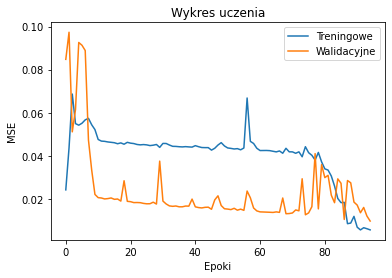

In [57]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Treningowe')
plt.plot(history.history['val_loss'], label='Walidacyjne')
plt.title('Wykres uczenia')
plt.xlabel('Epoki')
plt.ylabel('MSE')
plt.legend()
plt.show()


14/14 [==============================] - 1s 89ms/step


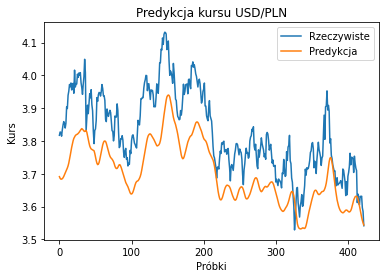

In [58]:
y_pred = model.predict(X_test)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred = scaler.inverse_transform(y_pred)

plt.plot(y_test, label='Rzeczywiste')
plt.plot(y_pred, label='Predykcja')
plt.title('Predykcja kursu USD/PLN')
plt.xlabel('Próbki')
plt.ylabel('Kurs')
plt.legend()
plt.show()

In [59]:
df2 = pd.read_csv('USD_PLN Historical Data.csv', usecols=['Date', 'Price', 'Open', 'High', 'Low'])

In [60]:
from keras.models import load_model

model = load_model('model.h5')


In [61]:
import datetime
import pandas as pd

# Konwertowanie kolumny 'Date' na obiekt datetime
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values(by='Date', ascending=False)

# Tworzenie sekwencji czasowych
time_stepsp = 10
X, y = create_sequences(df2[['Price', 'Open', 'High', 'Low']], df2['Price'], time_steps)
print("Ostatnie 30 dni, na których opieramy predykcję:\n", df2[['Date', 'Price', 'Open', 'High', 'Low']].head(time_stepsp))

# Skalowanie danych
scaler = MinMaxScaler()
df2['Price'] = scaler.fit_transform(df2['Price'].values.reshape(-1, 1))

# Tworzenie sekwencji czasowych
time_steps = 10
X, y = create_sequences(df2[['Price', 'Open', 'High', 'Low']], df2['Price'], time_steps)

# Wczytanie modelu
model = load_model('model.h5')

# Przewidywanie cen na kolejne 7 dni
predictions = []
current_sequence = X[-1]
for i in range(7):
    current_sequence = current_sequence.reshape(1, time_steps, 4)
    next_prediction = model.predict(current_sequence)
    last_date = df2['Date'].max()
    next_date = last_date + datetime.timedelta(days=1)
    predictions.append((next_date, next_prediction[0, 0]))
    new_prediction = np.array([[next_prediction[0, 0], 0, 0, 0]]).reshape(1, 1, 4)
    current_sequence = np.concatenate([current_sequence[:, 1:, :], new_prediction], axis=1)

# Odwrócenie skali i wyświetlenie wyników
predictions = scaler.inverse_transform(np.array(predictions)[:, 1].reshape(-1, 1))
date_range = pd.date_range(start=df2['Date'].max(), periods=7, freq='D')
predictions_with_dates = pd.DataFrame({'Date': date_range, 'Price': predictions.flatten()})
print("\nPrzewidywane ceny na najbliższe 7 dni:\n", predictions_with_dates)


Ostatnie 30 dni, na których opieramy predykcję:
         Date   Price    Open    High     Low
0 2023-04-14  4.2185  4.1950  4.2320  4.1834
1 2023-04-13  4.1933  4.2320  4.2396  4.1901
2 2023-04-12  4.2308  4.2769  4.2818  4.2280
3 2023-04-11  4.2752  4.3178  4.3197  4.2695
4 2023-04-10  4.3138  4.2847  4.3302  4.2845
5 2023-04-07  4.2811  4.2909  4.3039  4.2814
6 2023-04-06  4.2870  4.2956  4.3095  4.2819
7 2023-04-05  4.2918  4.2701  4.3064  4.2623
8 2023-04-04  4.2665  4.2867  4.2975  4.2625
9 2023-04-03  4.2841  4.3163  4.3436  4.2832
1/1 [==============================] - 0s 27ms/step

Przewidywane ceny na najbliższe 7 dni:
         Date     Price
0 2023-04-14  3.543817
1 2023-04-15  3.508572
2 2023-04-16  3.451469
3 2023-04-17  3.391948
4 2023-04-18  3.351097
5 2023-04-19  3.338264
6 2023-04-20  3.352258


1/1 [==============================] - 0s 21ms/step


C:\Users\mreliga\AppData\Local\Temp\ipykernel_22572\2966324061.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_data['Price'] = scaler.inverse_transform(historical_data['Price'].values.reshape(-1, 1))


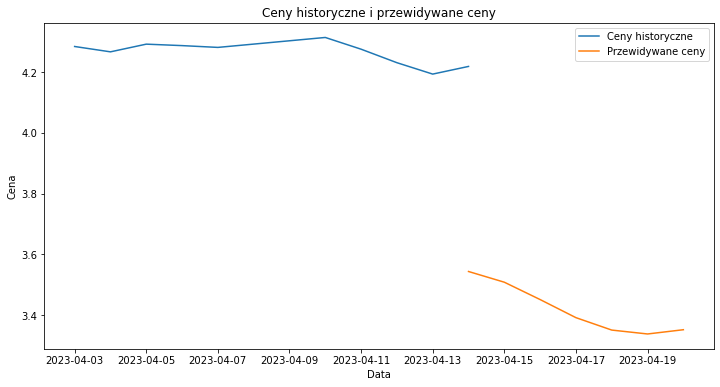

In [62]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt

# Konwertowanie kolumny 'Date' na obiekt datetime
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values(by='Date', ascending=False)

# Wczytanie modelu
model = load_model('model.h5')

# Tworzenie sekwencji czasowych
time_steps = 10
X, y = create_sequences(df2[['Price', 'Open', 'High', 'Low']], df2['Price'], time_steps)

# Przewidywanie cen na kolejne 7 dni
predictions = []
current_sequence = X[-1]
for i in range(7):
    current_sequence = current_sequence.reshape(1, time_steps, 4)
    next_prediction = model.predict(current_sequence)
    last_date = df2['Date'].max()
    next_date = last_date + datetime.timedelta(days=1)
    predictions.append((next_date, next_prediction[0, 0]))
    new_prediction = np.array([[next_prediction[0, 0], 0, 0, 0]]).reshape(1, 1, 4)
    current_sequence = np.concatenate([current_sequence[:, 1:, :], new_prediction], axis=1)

# Odwrócenie skali i przygotowanie danych do wykresu
historical_data = df2.head(time_steps)
historical_data['Price'] = scaler.inverse_transform(historical_data['Price'].values.reshape(-1, 1))
historical_data = historical_data.set_index('Date')
predictions = scaler.inverse_transform(np.array(predictions)[:, 1].reshape(-1, 1))
date_range = pd.date_range(start=df2['Date'].max(), periods=7, freq='D')
predictions_with_dates = pd.DataFrame({'Date': date_range, 'Price': predictions.flatten()})
predictions_with_dates = predictions_with_dates.set_index('Date')

# Wyświetlenie danych na wykresie
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(historical_data['Price'], label='Ceny historyczne')
ax.plot(predictions_with_dates['Price'], label='Przewidywane ceny')
ax.set_xlabel('Data')
ax.set_ylabel('Cena')
ax.set_title('Ceny historyczne i przewidywane ceny')
ax.legend()
plt.show();
